In [13]:
import pandas as pd
import numpy as np
data = np.load(r"C:\Personal\Educational\Projects\NLP-Reg\LLM_training.npz", allow_pickle=True)
df = pd.DataFrame({key: data[key] for key in data.files})

In [14]:
print(df.columns)

Index(['sample_id', 'catalog_content', 'value', 'unit', 'pack_size', 'ipq',
       'log_price', 'unit_clean', 'char_count', 'word_count',
       'avg_word_length', 'unique_word_ratio', 'premium_score',
       'organic_score', 'size_score', 'has_number', 'has_percent', 'has_pack',
       'has_discount', 'has_brand_like', 'llm_features', 'img_pca_128'],
      dtype='object')


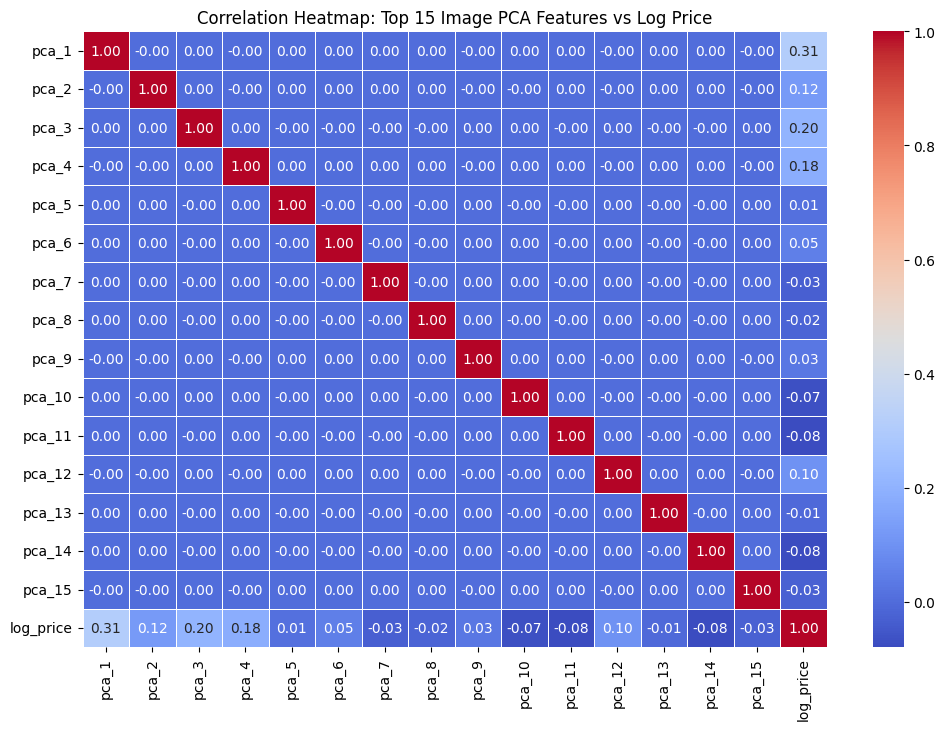

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Assume df is your DataFrame ---
# Each entry in 'img_pca_128' is a list or numpy array of 128 floats

# 1. Expand first 15 PCA components into separate columns
pca_cols = [f'pca_{i+1}' for i in range(15)]
pca_df = pd.DataFrame(df['img_pca_128'].apply(lambda x: x[:15]).to_list(), columns=pca_cols)

# 2. Combine with log_price
corr_df = pd.concat([pca_df, df['log_price']], axis=1)

# 3. Compute correlation matrix
corr_matrix = corr_df.corr()

# 4. Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Top 15 Image PCA Features vs Log Price")
plt.show()


In [18]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load your dataframe
# df = pd.read_csv('your_file.csv')

# Load the transformer model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Encode the catalog content into embeddings
embeddings = model.encode(df['catalog_content'].astype(str).tolist(), show_progress_bar=True)

# Save embeddings and sample IDs to a compressed .npz file
np.savez_compressed('catalog_embeddings.npz', 
                    sample_id=df['sample_id'].values, 
                    embeddings=embeddings)

print("Embeddings successfully saved to 'catalog_embeddings.npz'.")


Batches: 100%|██████████| 2344/2344 [09:47<00:00,  3.99it/s]


Embeddings successfully saved to 'catalog_embeddings.npz'.


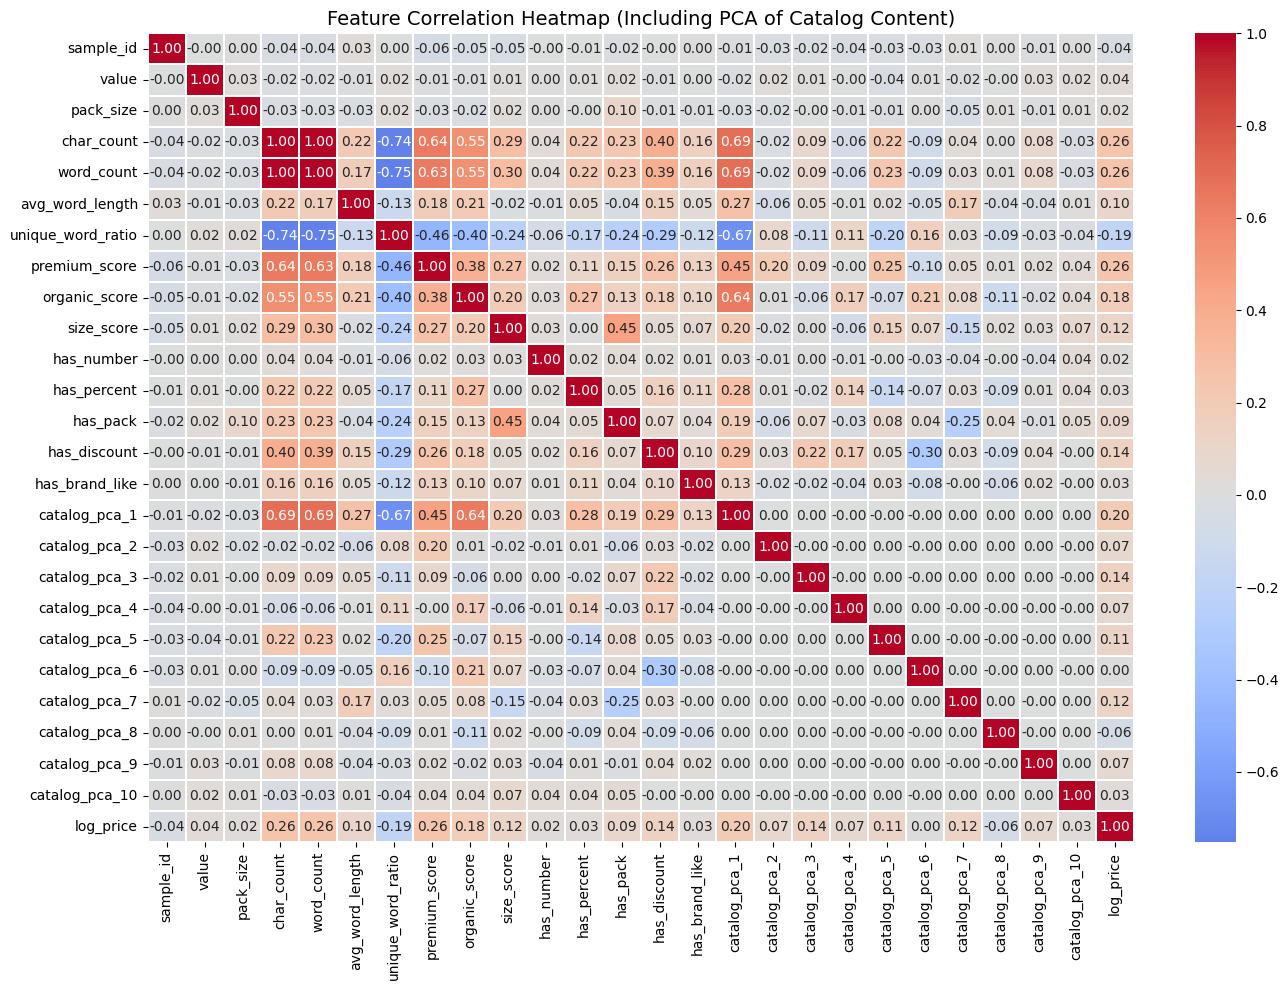

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Load the dataframe ---
# df = pd.read_csv('your_file.csv')

# --- Load the saved embeddings ---
data = np.load('catalog_embeddings.npz')
sample_ids = data['sample_id']
embeddings = data['embeddings']

# --- Align df with sample_ids ---
df = df.set_index('sample_id').loc[sample_ids].reset_index()

# --- Apply PCA to embeddings ---
pca = PCA(n_components=10, random_state=42)
pca_features = pca.fit_transform(embeddings)

# Add PCA components to dataframe
for i in range(10):
    df[f'catalog_pca_{i+1}'] = pca_features[:, i]

# --- Select numeric columns ---
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Drop 'img_pca_128' and 'ipq' if present
for col in ['img_pca_128', 'ipq']:
    if col in numeric_cols:
        numeric_cols.remove(col)

# Move 'log_price' to the end if it exists
if 'log_price' in numeric_cols:
    numeric_cols = [c for c in numeric_cols if c != 'log_price'] + ['log_price']

# --- Compute correlation matrix ---
corr_matrix = df[numeric_cols].corr()

# --- Plot heatmap with values ---
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=0.3)
plt.title("Feature Correlation Heatmap (Including PCA of Catalog Content)", fontsize=14)
plt.tight_layout()
plt.show()


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

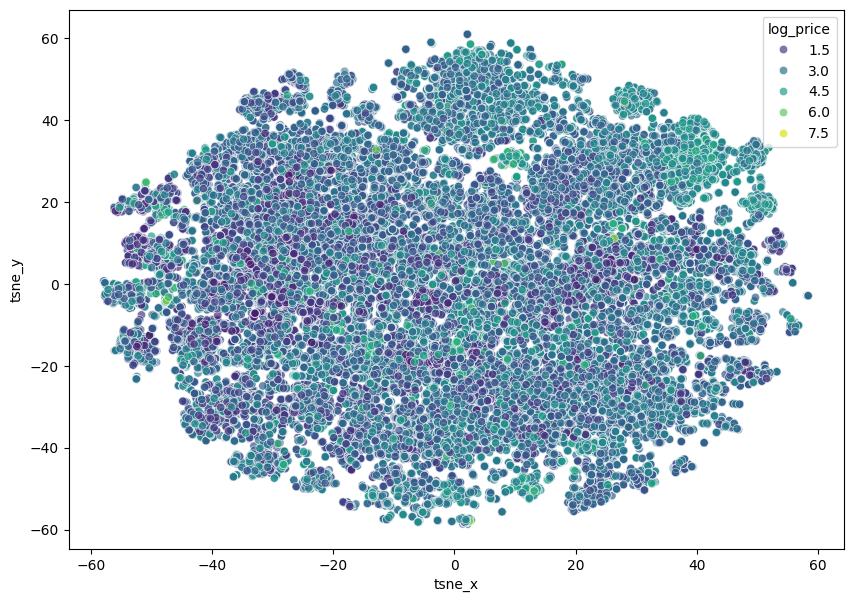

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# --- Load dataframe ---
# df = pd.read_csv('your_file.csv')

# --- Load saved embeddings ---
data = np.load('catalog_embeddings.npz')
sample_ids = data['sample_id']
embeddings = data['embeddings']

# --- Align df to ensure same order as embeddings ---
df = df.set_index('sample_id').loc[sample_ids].reset_index()

# --- Run t-SNE (2D visualization) ---
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,   # <-- changed from n_iter to max_iter
    random_state=42
)
tsne_embeds = tsne.fit_transform(embeddings)

# --- Add to dataframe ---
df['tsne_x'] = tsne_embeds[:, 0]
df['tsne_y'] = tsne_embeds[:, 1]

# --- Plot ---
plt.figure(figsize=(10, 7))
if 'log_price' in df.columns:
    sns.scatterplot(
        x='tsne_x', y='tsne_y',
        hue='log_price',
        data=df,
        palette='viridis',
        alpha=0.7
    )
    plt.colorbar(label='Log Price')
else:
    sns.scatterplot(x='tsne_x', y='tsne_y', data=df, alpha=0.7)

plt.title("t-SNE Visualization of Catalog Embeddings", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()


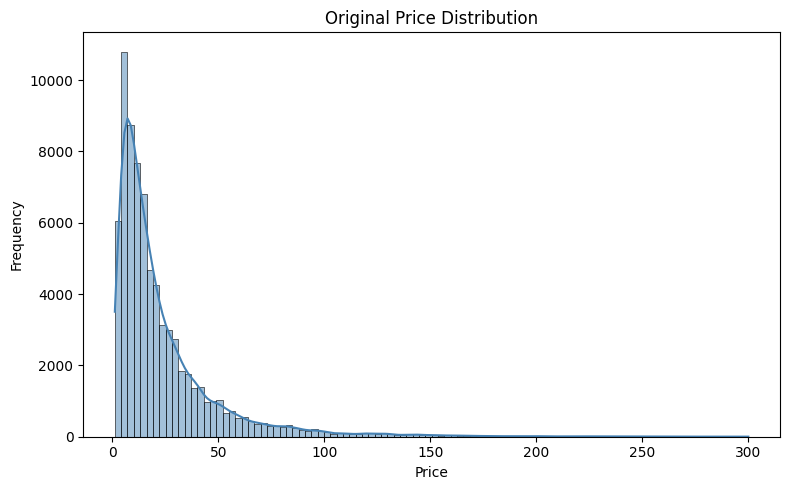

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df already loaded and has column 'price_log'
# Example:
# df = pd.read_csv("your_data.csv")

# 1️⃣ Take the anti-log (convert back to original price scale)
data = np.load(r"C:\Personal\Educational\Projects\NLP-Reg\LLM_training.npz", allow_pickle=True)
df = pd.DataFrame({key: data[key] for key in data.files})


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Anti-log transform
df['price'] = np.exp(df['log_price'])

# Cutoff at 500
df_cut = df[df['price'] <= 300]

# Plot thinner bars by increasing bin count
plt.figure(figsize=(8, 5))
sns.histplot(df_cut['price'], bins=100, kde=True, color='steelblue')

plt.title("Original Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


